# Stock Price Prediction 

In [67]:
(solving the wrong problem!) MARCOS FETURES

SyntaxError: invalid syntax (<ipython-input-67-9a58aa2f05fd>, line 1)

# I) Description of the problem

### On the problem.

* The problem of stock prediction concerns of being able to forecast a *Weakly Non stationary Time Series* so one can **sell** an active at a higher **Ask Price** that is was it's **Bid price** (buying at a smaller price than it was previously sold).


### On the properties of the data.

* Stocks, ETF's, hedge funds, can be modeled instantaneously as two Weakly Non stationary Time Series, one for *bid* prices and one for *ask* prices. By weakly Non stationary Time Series ($X(t)$), it is meant:

<center>
    First momentum invariance. (Trends in marked do not follow this)
</center>
$$E[X(t)] = E[X(t + \epsilon)]$$ <br/>




<center>
    Second momentum invariance. (Varying volatility of the market do not follow this)
</center>
$$C(X(t)) = C(X(t + \alpha)) = E[(X(t) - E[X(t)])(X(t + \epsilon) - E[X(t + \epsilon)])]$$ <br/>




<center>
    Bounded energy. (The very nature of inflation do not follow this)
</center>
$$E[|X(t)|^2] < \infty $$ <br/>




* So, one should interpret this data as not predictable for longer distances but, among several, one can depicts a few techniques to be able to predict those series. Namely:

    - Short term predictions: It transforms a non-stationary series in a locally stationary series. Thus, predictable.
    - Using the first order derivative ($r(t) = (x(t) - x(t - 1))$): It erases the 'memory' of a non-stationary series. This is also called **RETURNS** of a financial time series.


### On the financial data.

* **Bid's** and **Ask's** are updated at every new *order* in the *order book*, this is called *tick*. For visual chartists, analyzing this *tick* data is too cumbersome, so one of **many** ways of visualizing it, is in the form of **Open, Close, High, Low**, henceforth, nicknamed after *OCHL*. Those are defined as:

![title](assets/ochl.png)


* Among those who do trade stocks, we can find the ones so called *Scalpers* and the *Swing traders*, where, respectively, one places its buy/sell orders in the same day whereas the other waits for several days. We will be dealing with the former.

# II) Loading data

In [1]:
import requests
import quandl
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from collections import namedtuple

In [2]:
api_key = os.environ['QUANDL_API_KEY']
metadata_filename = 'WIKI_metadata.csv'
dataset_filename = 'WIKI_dataset.csv'
dates_range = ['2000-12-31', '2018-12-31']

## Downloading and extracting the dataset

In [3]:
import zipfile
def get_data(url, filename, extract=True):
    r = requests.get(url, allow_redirects=True)
    filename = filename + '.zip' if extract else filename
    open(filename, 'wb').write(r.content)
    if not extract: return
    zipfile.ZipFile(filename, 'r').extractall('./')

In [4]:
get_data('https://www.quandl.com/api/v3/databases/WIKI/metadata?api_key=%s' % api_key, 
         metadata_filename)

get_data('https://www.quandl.com/api/v3/datatables/WIKI/PRICES/delta.json?api_key=%s' % api_key, 
         dataset_filename, extract=False)

In [5]:
metadata_df = pd.read_csv(metadata_filename)
dataset_df = pd.read_csv(dataset_filename)

In [6]:
metadata_df.sample(10)

,code,name,description,refreshed_at,from_date,to_date
446,BWC,"Babcock & Wilcox Co. (BWC) Prices, Dividends, ...","<p>End of day open, high, low, close and volum...",2017-04-26 15:20:38,2010-08-02,2015-06-30
377,BKH,"Black Hills Corp. (BKH) Prices, Dividends, Spl...","<p>End of day open, high, low, close and volum...",2018-03-27 21:45:55,1984-09-07,2018-03-27
2735,T,"AT&T Inc (T) Prices, Dividends, Splits and Tra...","End of day open, high, low, close and volume, ...",2018-03-27 21:46:12,1984-07-19,2018-03-27
1034,FARM,"Farmer Brothers Company (FARM) Prices, Dividen...","<p>End of day open, high, low, close and volum...",2018-03-27 21:45:58,1990-03-26,2018-03-27
1061,FDS,"FactSet Research Systems Inc. (FDS) Prices, Di...","<p>End of day open, high, low, close and volum...",2018-03-27 21:45:58,1996-06-28,2018-03-27
1672,LGIH,"LGI Homes Inc. (LGIH) Prices, Dividends, Split...","<p>End of day open, high, low, close and volum...",2018-03-27 21:46:08,2013-11-07,2018-03-27
1826,MIL,"MFC Industrial Ltd. (MIL) Prices, Dividends, S...","<p>End of day open, high, low, close and volum...",2017-04-26 13:43:24,1996-05-08,2016-02-12
2165,PCAR,"PACCAR Inc (PCAR) Prices, Dividends, Splits an...","End of day open, high, low, close and volume, ...",2018-03-27 21:46:12,1986-07-09,2018-03-27
1290,GY,"GenCorp Inc. (GY) Prices, Dividends, Splits an...","<p>End of day open, high, low, close and volum...",2015-04-24 22:16:06,1981-02-02,2015-04-24
1170,FXEN,"FX Energy Inc. (FXEN) Prices, Dividends, Split...","<p>End of day open, high, low, close and volum...",2017-04-26 13:11:13,1996-06-11,2015-12-31


In [7]:
dataset_df

,"{""data"":{""files"":[]",latest_full_data:null}}


* Since the api for `get`'ing seems to be not working, we can use the **quandl** module to download the dataset.



* The WIKI dataset has a huge variety of stocks and assets, so, we'll be dealing with either **one** for regression or **four**  when building a portfolio.


In [8]:
quandl.ApiConfig.api_key = api_key

dataset_df = quandl.get_table('WIKI/PRICES', ticker = ['CENX', 'QCOM', 'YHOO', 'MCD'], 
                        date = {'gte': dates_range[0], 'lte': dates_range[1]},
                        paginate=True).reset_index(drop=True)
dataset_df.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,YHOO,2017-06-16,52.79,53.30,51.900,52.5892,251032146.0,0.0,1.0,52.79,53.30,51.900,52.5892,251032146.0
1,YHOO,2017-06-15,52.17,52.76,51.645,52.5800,65808136.0,0.0,1.0,52.17,52.76,51.645,52.5800,65808136.0
2,YHOO,2017-06-14,52.42,54.26,52.160,52.6300,65466397.0,0.0,1.0,52.42,54.26,52.160,52.6300,65466397.0
3,YHOO,2017-06-13,53.65,54.08,52.000,52.0050,152590970.0,0.0,1.0,53.65,54.08,52.000,52.0050,152590970.0
4,YHOO,2017-06-12,53.79,54.55,52.600,53.1200,57480339.0,0.0,1.0,53.79,54.55,52.600,53.1200,57480339.0


## Peaking on the data

In [9]:
from pandas.plotting import register_matplotlib_converters
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

data_to_plot = dataset_df[dataset_df.ticker == 'MCD'][['open', 'high', 'low', 'close', 'date']].copy()
data_to_plot['date'] = data_to_plot.date.map(mdates.date2num).copy()

In [319]:
%matplotlib inline

c:\python36\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


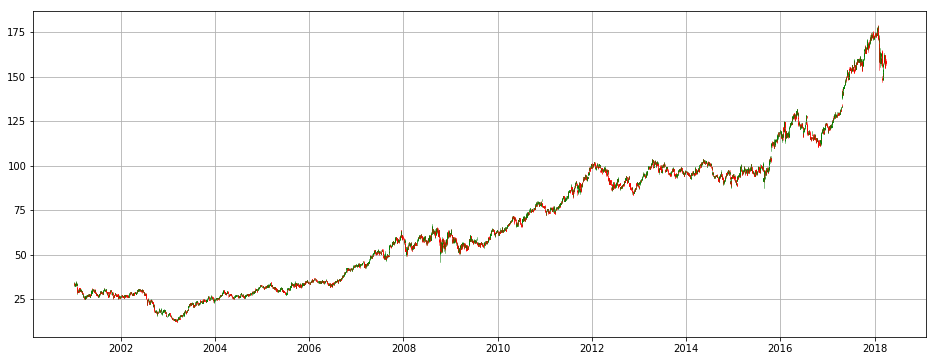

In [10]:
plt.figure(figsize=(16, 6))
ax = plt.subplot()
candlestick_ohlc(ax, data_to_plot[['date', 'open', 'high', 'low', 'close']].values, width=.5, colorup='g', colordown='r')
ax.xaxis_date()
ax.grid()
plt.show()

del data_to_plot

## Train, Validation and test split

* A **true** train/val/test split is one with no **leakage** to/from train/validation/test. 


* So ideally, the test should be another symbol (*e.g.*: train with **Tesla**, validate in another period of time using another asset). 


* But this would only prove the robustness and generalization of our model, while possibly, not maximizing profits in a single asset. Besides, multiple asset analysis is better done using a **Modern Portfolio Theory** (MPT, as proposed by *Markowitz*). 


* Thus, the split will be done in order to only avoid **lookahead bias** (train with day 1 and day 3, and test with day 2).


* Blocked Time Series Splits scheme of cross validation and training of our model will be used. We will also use a training in the whole data giving equal importance to all the data.


![title](assets/cross_validation2.png)


* For testing the data as soon as a architecture or algorithm is defined, we can use the Time Series Splits.:
![title](assets/cross_validation1.png)

In [11]:
TRAIN_VAL_PERCENTAGE = 0.85
TEST_PERCENTAGE = 1 - TRAIN_VAL_PERCENTAGE

full_dates_range = pd.date_range(start=dates_range[0], end=dates_range[1]).sort_values()

train_val_date_range = full_dates_range[:int(len(full_dates_range) * TRAIN_VAL_PERCENTAGE)].sort_values()
test_date_range = pd.DatetimeIndex(set(full_dates_range) - set(train_val_date_range)).sort_values()

In [22]:
dataset_df.loc[dataset_df.date.isin(train_val_date_range), 'set'] = 'TRAIN_VAL'
dataset_df.loc[dataset_df.date.isin(test_date_range), 'set'] = 'TEST'

In [13]:
class BlockingTimeSeriesSplit:
    def __init__(self, n_splits, train_val_percentage=0.8):
        self._train_val_percentage = train_val_percentage
        self._n_splits = n_splits
    
    @property
    def n_splits(self):
        return self._n_splits
    
    def split(self, X):
        n_samples = len(X)
        k_fold_size = n_samples // self._n_splits
        indices = np.arange(n_samples)

        for i in range(self._n_splits):
            begin = i * k_fold_size
            end = begin + k_fold_size
            mid = int(self._train_val_percentage * (end - begin)) + begin
            yield indices[begin:mid], indices[mid:end]

In [14]:
from sklearn.model_selection import TimeSeriesSplit

train_splits = BlockingTimeSeriesSplit(n_splits=6, train_val_percentage=TRAIN_VAL_PERCENTAGE)
testing_splits = TimeSeriesSplit(n_splits=4)

# III) Feature engineering

* As discussed in the first section, it is useful to transform the OCHL features to something manageable mathematically, such as, a (locally) stationary time series.


In [15]:
primary_features_columns = ['open', 'high', 'low', 'close', 'volume']

In [16]:
features_df = dataset_df[primary_features_columns + ['ticker', 'set', 'date']].copy()

## Analytical features

### Daily returns.

* One can use the relative returns of one single day as feature, since it is a first order derivative, thus, conveying stationarity to out time series.

$$\frac{X(t_{close})}{X(t_{open})} - 1$$

In [17]:
features_df['daily_returns'] = (features_df.close / features_df.open) - 1

### Log returns.

* Among the advantages explored in the **section I)** of using returns instead of the raw data, we can further improve the feature of time series so it displays desirable statistical properties. One usual transform is known as **Log-returns**, defined as follows:


$$log(\frac{X(t)}{X(t-1)})$$


* The desirable properties of using log-returns can be summed in as being prone to follow a normal distribution and being able to "accumulate" returns over time with simple additions instead of multiplications)

In [18]:
def log_returns(dataframe):
    sorted_dataframe = dataframe.sort_values(by='date')
    sorted_dataframe['log_returns'] = np.log(sorted_dataframe.close / sorted_dataframe.close.shift(1))
    return sorted_dataframe
    
features_df = features_df.groupby('ticker')\
    .apply(log_returns).droplevel(0)

## Market Features (Techinical indicators)

* For traders who are used to manually trade, It's often used a common analysis called **Technical Analysis**, in which allegedly, it is possible to infer market movements such as *momentum*, *overbought*, *oversold*, *breakout break* and *support breakout* through **technical indicators** such as (*e.g.* MACD, RSI, EMA, Bollinger Bands, Stochastic oscillators).



* There are **no**$^{I}$  proves so far that technical indicators have any real predictive power over the market besides the mere fact that human traders, hedge funds and firms tend to use them, so, by the efficient market hypothesis, the market will react in accordance with those buyers and sellers.


* Thus, we are going to use one of those indicators because it can at least predict if traders are using it too much or otherwise.




<sup>$^{I}$: *Burton G. Malkiel*, A randon walk down wall street.<sup>

### Price-Volume Trend

* Sharp changes in the price that follows a sharp change in volume usually represents a **resistance** or **support**, meaning that traders will consider the market overbought (or oversold) and start to sell (or buy).


* On Balance Volume (OBV) Is an indicator that simply adds or subtracts the volume from a accumulator depending on the return of the current day.

In [19]:
def on_balance_volume(dataframe):
    sorted_dataframe = dataframe.sort_values(by='date')
    previous_row = None
    def _compute_obv_for_row(row):
        nonlocal previous_row
        if previous_row is not None:
            row['obv'] = previous_row['obv'] + row['volume'] if row['close'] > previous_row['close'] else\
                         previous_row['obv'] - row['volume'] if row['close'] < previous_row['close'] else\
                         previous_row['obv']
        else:
            row['obv'] = np.nan
            previous_row = row.copy()
            previous_row['obv'] = .0
        return row

    return sorted_dataframe.apply(_compute_obv_for_row, axis=1)

features_df = features_df.groupby('ticker')\
    .apply(on_balance_volume).reset_index(drop=True)

### Normalization

* In order give no priors to our models, the available features will be normalized by their respective standard deviation in the train so they have the same *a-priori* importance, since their power will always be 1.

In [20]:
def normalize(dataframe):    
    feature_columns = primary_features_columns + ['daily_returns', 'log_returns', 'obv']
    _features_df = dataframe[feature_columns]
    _features_df = _features_df.div(_features_df[dataframe.set == 'TRAIN_VAL'].std())
    
    dataframe[feature_columns] = _features_df
    return dataframe
    
features_df = features_df.groupby('ticker')\
    .apply(normalize).reset_index(drop=True)

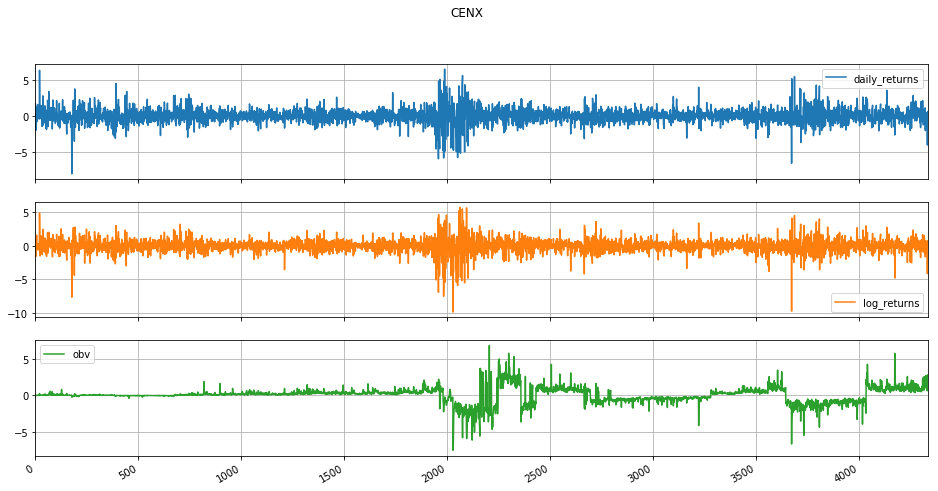

In [21]:
features_df[features_df.ticker == 'CENX'][['daily_returns', 'log_returns', 'obv']]\
    .plot(subplots=True, figsize=(16, 8), grid=True, title='CENX')
plt.show()

# IV) Training


## Regression

* Windows of five days of features with 3 days of overlap will be used for the regression task.

In [361]:
ASSET_FOR_REGRESSION = 'MCD'

## Create samples for train

In [416]:
Samples = namedtuple('Samples', ['windowed_features', 'scalar_features', 'target'])

In [417]:
train_val_set = features_df[(features_df.ticker == ASSET_FOR_REGRESSION) &\
                            (features_df.set == 'TRAIN_VAL')]

train_val_set = train_val_set[primary_features_columns + ['daily_returns', 'log_returns', 'obv', 'date']]\
                .sort_values('date')\
                .reset_index(drop=True)

In [429]:
def get_samples_and_targets(
        dataframe, *, 
        target_column, windowed_features_columns=[], 
        scalar_features_columns=[], window_size=5, overlap=3
):
    return [
        Samples(
            windowed_features=dataframe.iloc[idx - window_size:idx][windowed_features_columns].values.copy(),
            scalar_features=dataframe.iloc[idx - 1][scalar_features_columns].values.copy(),
            target=dataframe.iloc[idx][target_column].copy(),
        )
        for idx in range(window_size, len(dataframe), window_size - overlap)
    ]


In [430]:
train_samples = get_samples_and_targets(
    train_val_set, 
    target_column='close',
    windowed_features_columns=['open', 'high', 'low', 'close'], 
    scalar_features_columns=['daily_returns', 'log_returns', 'obv'],
    window_size=5, overlap=3)